![Spark Logo](http://spark-mooc.github.io/web-assets/images/ta_Spark-logo-small.png) + ![Python Logo](http://spark-mooc.github.io/web-assets/images/python-logo-master-v3-TM-flattened_small.png)
# **Text Analysis of Beer Reviews**
Here we use pySpark to analyze the text in the commercial description and review text to create similarity scores between beers.  The scores can then be used for clustering and beer style identification or to find beers similar to what a user enjoys, as a recommendation service.

### **Preliminaries**
#### We read in the allBeer.txt file and create an RDD consisting of lines.
#### We want to remove the header from the file, so the parseDataFileLine function identifies lines starting with 'beer_id' and applies a flag of 0, other lines with the correct number of fields are flagged 1, and incorrect lines are flagged -1.  The lines are split into arrays.

In [1]:
import re

def parseDatafileLine(datafileLine):
    ##Parse a line of the data file using the specified regular expression pattern
    splitArray = datafileLine.split("\t")
    for x in range(0,len(splitArray)):
        splitArray[x]=splitArray[x].replace("\"",'')
    #print len(splitArray)
    #print splitArray[0],splitArray[1],splitArray[2]
    if splitArray[0]=='beer_id':
        return (splitArray,0)
    elif len(splitArray)<>23:
        ##this is a failed parse
        return (splitArray,-1)
    else:
        return (splitArray, 1)

### Reading the file
#### We read the file into three rdds by first parsing the file as above, the header rdd, failed rdd and the valid rdd.  Print the header names so we can remember what fields we're dealing with and in what order.

In [2]:
import sys
import os

baseDir = os.path.join('')
allBeer_Path = 'AllBeer.txt'
STOPWORDS_PATH = 'stopwords.txt'

def parseData(filename):
    #Parse a data file returns a RDD of parsed lines
    
    return (sc
            .textFile(filename, 4, 0)
            .map(parseDatafileLine)
            .cache())

def loadData(path):
    ##Load a data file, returns a RDD of parsed valid lines
    
    filename = os.path.join(baseDir, path)
    raw = parseData(filename).cache()
    failed = (raw
              .filter(lambda s: s[1] == -1)
              .map(lambda s: s[0]))
    for line in failed.take(10):
        print '%s - Invalid datafile line: %s' % (path, line)
    valid = (raw
             .filter(lambda s: s[1] == 1)
             .map(lambda s: s[0])
             .cache())
    header = (raw
              .filter(lambda s: s[1]==0)
             .map(lambda s:s[0])
             )
    for line in header.take(1):
        for x in range(0,len(line)):
            print x,line[x]
            
    rawLines = raw.count()
    validLines = valid.count()
    failedLines = failed.count()
    print '%s - Read %d lines, successfully parsed %d lines, failed to parse %d lines' % (path, rawLines, validLines,failedLines)
    return valid
    
allBeer = loadData(allBeer_Path)
#allReviews = loadData(allReviews_Path)

0 beer_id
1 beer_name
2 brewer_name
3 beer_style
4 distribution
5 brewery_location
6 commercial_desc
7 RATINGS: 
8 MEAN (/5)
9 WEIGHTED AVG
10 EST. CALORIES
11 ABV (%)
12 IBU
13 SCORE
14 AROMA (/10)
15 APPEARANCE(/5)
16 TASTE(/10)
17 PALATE(/5)
18 OVERALL(/20)
19 reviewer_name
20 review_location
21 review_date
22 review_content
AllBeer.txt - Read 240355 lines, successfully parsed 240354 lines, failed to parse 0 lines


### Let's examine the first few entries of a sample of 5 lines to check if things look ok.

In [3]:
sampleArray=allBeer.takeSample(False,5,1)
for line in sampleArray:
    print len(line)
    print 'allBeer: %s, %s, %s, %s, %s\n' % (line[0], line[1], line[2],line[3],line[4])

23
allBeer: 40920, Wernecker Haustrunk Pils, Wernecker Bierbrauerei, Pilsener, distribution unknown

23
allBeer: 21911, Au Ma'tre Brasseur La Boucaneuse, AMB - Ma'tre Brasseur, Smoked, distribution unknown

23
allBeer: 4991, New Albanian / Struise Naughty Girl, New Albanian Brewing Company, India Pale Ale (IPA), Regional Distribution

23
allBeer: 38430, BrewDog IPA is Dead - Pioneer, BrewDog, India Pale Ale (IPA), Broad Distribution

23
allBeer: 41353, Cascade Cerise Nouveau, Cascade Brewing, Sour/Wild Ale, Local Distribution



### Now we'll split the data into a training set (80%) and test set (%20).  
#### This is slightly complicated by the fact that we want to split each user into 80/20, not the set of reviews as a whole.  We will take advantage of stratified sampling in Spark, grouping the reviews by the user name, then sampling by key.  To get the unused data we employ subtractByKey using a compound key of the username and the beer_id, guaranting uniqueness.

In [4]:
##Using the allBeer array, take stratified sample, and remove blank reviews.
beerByUser = allBeer.map(lambda x:(x[19],x)).filter(lambda (x,y):y[22]!='')
sampleKeys = beerByUser.keys().collect()
fractions={}
for k in sampleKeys:
    fractions[k]=0.8
    
beerTrain = beerByUser.sampleByKey(False,fractions).cache()
beerTrainKeyed = beerTrain.map(lambda (x,y):(y[0]+y[19],y))
beerTest = allBeer.map(lambda x:(x[0]+x[19],x)).subtractByKey(beerTrainKeyed).map(lambda (x,y):(y[19],y)).cache()
print beerByUser.count()
print beerTrain.count()
print beerTest.count()

240334
192184
48170


### Let's examine the results with a couple of random users.

In [5]:
from numpy.random import random_integers
##find a random user and print out the train and test set.
randomUsers = random_integers(1,len(sampleKeys),2)
sampleUserReviewCount = beerByUser.filter(lambda (x,y):x==sampleKeys[randomUsers[0]]).count()
sampleUserTrainCount = beerTrain.filter(lambda (x,y):x==sampleKeys[randomUsers[0]]).count()
sampleUserTestCount = beerTest.filter(lambda (x,y):x==sampleKeys[randomUsers[0]]).count()
print "The user %s has %d reviews, split into %d Train and %d Test" % (sampleKeys[randomUsers[0]],sampleUserReviewCount,sampleUserTrainCount,sampleUserTestCount)

sampleUserReviewCount = beerByUser.filter(lambda (x,y):x==sampleKeys[randomUsers[1]]).count()
sampleUserTrainCount = beerTrain.filter(lambda (x,y):x==sampleKeys[randomUsers[1]]).count()
sampleUserTestCount = beerTest.filter(lambda (x,y):x==sampleKeys[randomUsers[1]]).count()
print "The user %s has %d reviews, split into %d Train and %d Test" % (sampleKeys[randomUsers[1]],sampleUserReviewCount,sampleUserTrainCount,sampleUserTestCount)

The user hallinghansen has 106 reviews, split into 81 Train and 25 Test
The user Stoned99 has 193 reviews, split into 151 Train and 42 Test


### Scale the reviews:
#### Each user has a different way of scoring beers, some people judge more harshly than others.  In order to even out these scores, we get get statistics for each user and adjust their scores to fit a common distribution.  In this particular case we use a normal distribution for it's simplicity to execute.  Users with 1 or less reviews will have a standard deviation of 0, in which case we substitute 1 to ensure the division when obtaining z-scores we will not divide by zero.

In [6]:
from math import sqrt
##13 SCORE
##14 AROMA (/10)
##15 APPEARANCE(/5)
##16 TASTE(/10)
##17 PALATE(/5)
##18 OVERALL(/20)

def replaceZeroes(inputValue,replacementValue):
    if inputValue == 0:
        inputValue = replacementValue
    return inputValue

def subtractFromColumn(inputList,columnToChange,subtractAmount):
    inputList[columnToChange]=float(inputList[columnToChange])-subtractAmount
    return inputList

def divideColumn(inputList,columnToChange,divisor):
    inputList[columnToChange]=float(inputList[columnToChange])/divisor
    return inputList


### rewrite this to be RDD of (key,everything else) and return (key, everything with normalized column x)
### Then run a few times and cache, and move this up into the preliminaries (post split)
def normalizeScoreByKey(inputRDD,scoreColumn):
    ##Takes in RDD of (key,array) and 
    ##returns RDD of (key,array with scoreColumn normalized)
    sumScores = inputRDD.map(lambda (x,y):(x,float(y[scoreColumn]))).reduceByKey(lambda a,b:a+b)
    #print sumScores.map(lambda (x,y):y).reduce(lambda a,b:a+b)
    countScoresPerKey = inputRDD.map(lambda (x,y):(x,1)).reduceByKey(lambda a,b:a+b)
    #print countKeys.map(lambda (x,y):y).reduce(lambda a,b:a+b)
    averageScores = sumScores.join(countScoresPerKey).map(lambda (x,y):(x,y[0]/y[1]))
    #print averageScores.takeSample(False,5,3)
    centredScores = inputRDD.join(averageScores).map(lambda (x,(y,z)):(x,subtractFromColumn(y,scoreColumn,z)))
    #print centredScores.map(lambda (x,y):y[scoreColumn]).reduce(lambda a,b:a+b)
    centredScoresSquaredSum = centredScores.map(lambda (x,y):(x,y[scoreColumn]*y[scoreColumn])).reduceByKey(lambda a,b:a+b)
    centredScoresSquaredSumAndCount = centredScoresSquaredSum.join(countScoresPerKey)
    stdDeviationByKey = centredScoresSquaredSumAndCount.map(lambda (x,y):(x,sqrt(y[0]/y[1])))
    ##This is actually pointless since a centred score is 0 and 0/anything = 0
    ##countLines = stdDeviationByUser.count()
    ##avgStdDev = stdDeviationByUser.map(lambda (x,y):y).reduce(lambda a,b:a+b)/countLines
    stdDeviationByKeyNoZero = stdDeviationByKey.map(lambda (x,y):(x,replaceZeroes(y,1)))
    normalizedRDD = centredScores.join(stdDeviationByKeyNoZero).map(lambda (x,(y,z)):(x,divideColumn(y,scoreColumn,z)))
    return normalizedRDD

##Normalize the Scores
normalizedScores = normalizeScoreByKey(beerTrain,13)
##Normalize the rest of the ratings
#beerTrainNormA = normalizeScoreByKey(normalizedScores,14)
#beerTrainNormB = normalizeScoreByKey(beerTrainNormA,15)
#beerTrainNormC = normalizeScoreByKey(beerTrainNormB,16)
#beerTrainNormD = normalizeScoreByKey(beerTrainNormC,17)
beerTrainNormalized = normalizeScoreByKey(normalizedScores,18).cache()

print beerTrainNormalized.takeSample(False,5,4)


[('Lubiere', ['22239', 'La Souche St-Jones', 'La Souche', 'Abbey Dubbel', 'distribution unknown', 'Quebec City, Canada', 'No commercial description', '3.000', '3.100', '2.860', '192.000', '6.400', '', 0.16922201133172543, '7.000', '3.000', '7.000', '3.000', 0.2051353107202715, 'Lubiere', 'Ottawa, Ontario, CANADA ', 'SEP 27, 2014', 'A reddish copper ale with a thin mocha head. In aroma, nice fruity malt with candy sugar, caramel, dark fruits, molasses, nice. In mouth, a nice sweet fruity malt with light caramel malt, candy sugar, plums, nice. On tap at brewery. ']), ('Beerhunter111', ['6977', 'De Molen Nood & Deugd (Necessity & Virtue)', 'Brouwerij de Molen', 'Schwarzbier', 'distribution unknown', 'Bodegraven, Netherlands', "Sometimes things go wrong at a brewery. While brewing our Donder & Bliksem a mistake was made and we added a lot of malts that weren't suppose to go in this brew. This is how our Bohemian Lager turned into a Schwarzbier. As you see, we turn our Difficulties into a V

### **Normalized Histograms**
#### Plot histograms of the normalized ratings to check to see if normality approximately holds.
#### Clearly score and overall are not normal, skewed right.  This would imply that when people hate a beer, they're more willing to review it harshly than they are willing to give a glowing review to a beer they love.

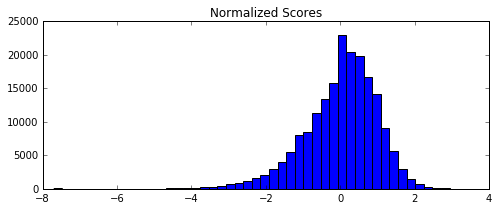

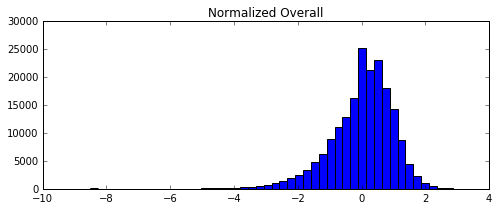

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
##Get all the normalized scores into one list.
scoreValues = beerTrainNormalized.map(lambda (x,y): y[13]).collect()
fig = plt.figure(figsize=(8,3))
plt.title('Normalized Scores')
plt.hist(scoreValues, 50, log=False)
overallValues = beerTrainNormalized.map(lambda (x,y): y[18]).collect()
fig = plt.figure(figsize=(8,3))
plt.title('Normalized Overall')
plt.hist(overallValues, 50, log=False)
pass

### Let's think about the test data set as if it were a menu in a pub
#### For each of the beers on the menu we need to generate a score, to see how compatable the beer is with the beer drinker's tastes.  From these scores we can then order the list, best to worst and the user can make their choice.  To do that we first need to know what the user likes, so let's take a look at their reviews and generate a list of traits, with each trait weighted by their own review scores.

### Step 1: Making Bags of Words
#### We can take the commercial descriptions and the user input text reviews and convert them into bags of words, we can then treat each word as a feature.  
#### We should take out stopwords before we do this, to avoid unfairly weighting reviews based on words which don't contribute much meaning, such as "the", "a", "is", "which", etc.

In [8]:
stopfile = os.path.join(baseDir, STOPWORDS_PATH)
stopwords = set(sc.textFile(stopfile).collect())
testString = "This is a test of the tf function.  It should return non stopword frequencies frequency sourness"
print 'These are the stopwords: %s' % stopwords
split_regex = r'\W+'

#from nltk.stem.porter import PorterStemmer
#Stmmr = PorterStemmer()

def tokenize(string):
    ##takes in a string and tokenizes it, removing stopwords, returns list
    simple=filter(None,re.split(split_regex,string.lower()))
    #simple = [Stmmr.stem(i) for i in simple]
    return [i for i in simple if i not in stopwords]

print tokenize(testString)

These are the stopwords: set([u'all', u'just', u'being', u'over', u'both', u'through', u'yourselves', u'its', u'before', u'with', u'had', u'should', u'to', u'only', u'under', u'ours', u'has', u'do', u'them', u'his', u'very', u'they', u'not', u'during', u'now', u'him', u'nor', u'did', u'these', u't', u'each', u'where', u'because', u'doing', u'theirs', u'some', u'are', u'our', u'ourselves', u'out', u'what', u'for', u'below', u'does', u'above', u'between', u'she', u'be', u'we', u'after', u'here', u'hers', u'by', u'on', u'about', u'of', u'against', u's', u'or', u'own', u'into', u'yourself', u'down', u'your', u'from', u'her', u'whom', u'there', u'been', u'few', u'too', u'themselves', u'was', u'until', u'more', u'himself', u'that', u'but', u'off', u'herself', u'than', u'those', u'he', u'me', u'myself', u'this', u'up', u'will', u'while', u'can', u'were', u'my', u'and', u'then', u'is', u'in', u'am', u'it', u'an', u'as', u'itself', u'at', u'have', u'further', u'their', u'if', u'again', u'no', u

### **Tokenizing the Commercial Description and Review**
#### Now tokenize the commercial descriptions and reviews. 
#### To see how much data we're dealing with let's count the total number of tokens.

In [9]:
##6 commercial description
##22 user input review
##make an RDD where the user_id is the key, and the value is 2 arrays of tokens 
##and the original line
beerTrainToToken = beerTrainNormalized.map(lambda (x,y):(y[19],(tokenize(y[6]),tokenize(y[22]),y)))

def countTokens(textRDD,reviewTRUE):
    ## Count and return the number of tokens
    if reviewTRUE==True:
        return textRDD.map(lambda (x,y):len(y[1])).reduce(lambda a,b:a+b)
    else:
        return textRDD.map(lambda (x,y):len(y[0])).reduce(lambda a,b:a+b)

print 'There are %s tokens in the commercial descriptions' % countTokens(beerTrainToToken,False)
print 'There are %s tokens in the reviews' % countTokens(beerTrainToToken,True)

There are 4656566 tokens in the commercial descriptions
There are 6667984 tokens in the reviews


### Let's get an idea of how big a review is

In [10]:
def findBiggestRecord(textRDD,reviewTRUE):
    # Find and return the record with the largest number of tokens
    if reviewTRUE==True:
        return textRDD.takeOrdered(1,lambda (x,y):-len(y[1]))
    else:
        return textRDD.takeOrdered(1,lambda (x,y):-len(y[0]))

def findSmallestRecord(textRDD,reviewTRUE):
    # Find and return the record with the largest number of tokens
    if reviewTRUE==True:
        return textRDD.takeOrdered(1,lambda (x,y):len(y[1]))
    else:
        return textRDD.takeOrdered(1,lambda (x,y):len(y[0]))

biggestReview = findBiggestRecord(beerTrainToToken,True)
print 'The review from user "%s" has the most tokens (%s)' % (biggestReview[0][0],
                                                                   len(biggestReview[0][1][1]))
smallestReview = findSmallestRecord(beerTrainToToken,True)
print 'The review from user "%s" has the least tokens (%s)' % (smallestReview[0][0], len(smallestReview[0][1][1]))

The review from user "SlovakSniper" has the most tokens (579)
The review from user "Shurf" has the least tokens (0)


### So clearly we've got some reviews that are empty, and we'll need some special handling for those.

### **Step 2: Weighted Bag-of-Words using TF-IDF**

### Term Frequency (TF) 
#### This gives higher weight to tokens that appear many times in a individual document. It is computed as the frequency of a token in a document. If a word occurs often in a document, then it is more important to the meaning of the document.

In [11]:
testString = "This is a test of the tf function.  It should return non stopword frequencies"
def tf(tokens):
    ###Compute TF from list of tokens, return dictionary of word:tf
    count = len(tokens)
    words={}
    for token in tokens:
        words[token]=float(len([t for t in tokens if t==token]))/count
    return words

print tf(tokenize(testString))

{'function': 0.14285714285714285, 'non': 0.14285714285714285, 'return': 0.14285714285714285, 'frequencies': 0.14285714285714285, 'stopword': 0.14285714285714285, 'tf': 0.14285714285714285, 'test': 0.14285714285714285}


### Inverse Document Frequency
#### This gives higher weight to tokens that are rare over the entire dataset. The rationale is two documents are more alike if they have in common words which are not common to rest data set.  IDF weight for a token in a set of documents is calculated as D/d(t) where D is the total number of documents and d(t) is the number of documents with term t.  
#### We want to find out what is special to each individual, so the IDF needs to be across all beer reviews.

In [14]:
def countEachToken(listOfTokens):
    ##Count the number of times each token appears in the list
    tokenSet = list(set(listOfTokens))
    tokenDict={}
    for token in tokenSet:
        tokenDict[token]=0
    for token in listOfTokens:
        tokenDict[token]=tokenDict[token]+1
    return tokenDict

def divideIntByDict(inputDict,inputInt):
    for entry in inputDict:
        inputDict[entry]=float(inputInt)/float(inputDict[entry])
    return inputDict

##IDFByKey is depricated, it just didn't make sense to pick words which each user used rarely.
def IDFByKey(keyCorpus):
    uniqueTokens = keyCorpus.map(lambda (x,y):(x,list(set(y))))
    tokensByKey = uniqueTokens.reduceByKey(lambda a,b:a+b)
    tokensCountByKey = tokensByKey.map(lambda (x,y):(x,countEachToken(y)))
    countDocsByKey=keyCorpus.map(lambda (x,y):(x,1)).reduceByKey(lambda a,b:a+b)
    countDocsAndTokensByKey = tokensCountByKey.join(countDocsByKey)
    IDF=countDocsAndTokensByKey.map(lambda (x,y):(x,divideIntByDict(y[0],y[1])))
    return IDF

def IDFWhole(keyCorpus):
    N = keyCorpus.count()
    uniqueTokens = keyCorpus.map(lambda (x,y):list(set(y))).flatMap(lambda y:y)
    tokenCountPairTuple = uniqueTokens.map(lambda y:(y,1))
    tokenSumPairTuple = tokenCountPairTuple.reduceByKey(lambda a,b:a+b)
    IDFs = tokenSumPairTuple.map(lambda (k,V):(k,float(N)/V))
    return IDFs

#RDD of (beer_id,text)
reviewTokens = beerTrainToToken.map(lambda (x,y):(x,y[1]))
#reviewIDF=IDFByKey(reviewTokens)
##make this a broadcast variable, so each node has it.
reviewIDF=IDFWhole(reviewTokens)
print reviewIDF.take(5)
#print reviewIDF.takeSample(False,2,1)

[('notws', 192184.0), ('madsen', 192184.0), ('zpienione', 192184.0), ('vermilion', 96092.0), ('wexford', 48046.0)]


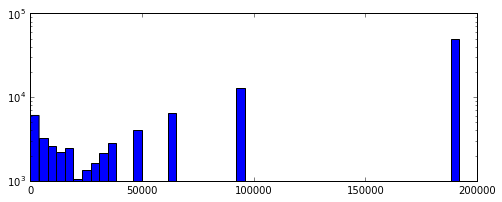

In [15]:
idf_values = reviewIDF.map(lambda s: s[1]).collect()
fig = plt.figure(figsize=(8,3))
plt.hist(idf_values, 50, log=True)
pass

### **Implement a TF-IDF function**
#### We want to weight the individual features (words) by the user's given scores.  This should increase the weightings of words used only in positive reviews and greatly increase rare words in positive reviews.  We then create an RDD of (key, dictionary) where the dictionary is a ranked collection of each user's individual preferences.  We have a customized set of features which indicate what a user likes.

In [16]:
def multiplyDict(inputDict,multiplier):
    #multiplies every entry in a dictionary by a number.
    for item in inputDict:
        inputDict[item]=inputDict[item]*multiplier
    return inputDict

def stf(tokens, score):
    ### Compute S-TF
    tfsDict = tf(tokens)
    stfsDict = multiplyDict(tfsDict,score)
    return stfsDict

def multiplyTwoDicts(firstDict,secondDict):
    multDict = {token:firstDict[token]*secondDict[token] for token in firstDict}
    return multDict

def addTwoDicts(firstDict,secondDict):
    for token in firstDict:
        if token in secondDict:
            firstDict[token]=firstDict[token]+secondDict[token]
    for token in secondDict:
        if token in firstDict:
            pass
        else:
            firstDict[token]=secondDict[token]            
    return firstDict

def stfidf(tokens, idfs, score):
    """ Compute TF-IDF
    Args:
        tokens (list of str): input list of tokens from tokenize
        idfs (dictionary): record to IDF value
    Returns:
        dictionary: a dictionary of records to TF-IDF values
    """
    tfs = stf(tokens)
    tfIdfDict = {token:tfs[token]*idfs[token] for token in tfs}
    return tfIdfDict

##13 SCORE
##14 AROMA (/10)
##15 APPEARANCE(/5)
##16 TASTE(/10)
##17 PALATE(/5)
##18 OVERALL(/20)

def stfidfByKey(inputRDD,idfRDD,reviewTrue,whichRating):
    ##Takes RDD of form (key,(list,list,wholebeer)) and calculates the s-tf of 
    ##reviewTrue==True ===> review
    ##reviewTrue==False ===> commercial Description
    ##whichRating ==-1 => don't weight by any column, just use 1 as a factor
    ##takes the sum of s-tf and applies the idf to it.
    
    if (whichRating < 13 or whichRating > 18) and whichRating!=-1:
        raise ValueError('whichRating must be between 13 and 18 or equal to 0, please refer to documentation about fields')
                         
    if reviewTrue==True:
        if whichRating!=-1:
            stfRDD = inputRDD.map(lambda (x,(a,b,c)):(x,stfidf(b,idfRDD,float(c[whichRating])))).reduceByKey(addTwoDicts)
        else:
            stfRDD = inputRDD.map(lambda (x,(a,b,c)):(x,stfidf(b,idfRDD,1))).reduceByKey(addTwoDicts)
        #print stfRDD.takeSample(True,3,1)
    else:
        if whichRating!=-1:
            stfRDD = inputRDD.map(lambda (x,(a,b,c)):(x,stfidf(a,idfRDD,float(c[whichRating])))).reduceByKey(lambda a,b:a+b)
        else:
            stfRDD = inputRDD.map(lambda (x,(a,b,c)):(x,stfidf(a,idfRDD,1))).reduceByKey(lambda a,b:a+b)
            
    stfidfRDD=stfRDD.map(lambda (x,(y,z)):(x,multiplyTwoDicts(y,z)))
    #print stfidfRDD.takeSample(True,3,1)
    return stfidfRDD

def stfidfReduced(inputRDD,idfRDD,reviewTrue,whichRating):
    ##Takes RDD of form (key,(list,list,wholebeer)) and calculates the s-tf of 
    ##reviewTrue==True ===> review
    ##reviewTrue==False ===> commercial Description
    ##whichRating ==-1 => don't weight by any column, just use 1 as a factor
    ##takes the sum of s-tf and applies the idf to it.
    
    if (whichRating < 13 or whichRating >18) and whichRating!=-1:
        raise ValueError('whichRating must be between 13 and 18 or equal to 0, please refer to documentation about fields')
                         
    if reviewTrue==True:
        if whichRating!=-1:
            stfidfRDD = inputRDD.map(lambda (x,(a,b,c)):(x,(stf(b,float(c[whichRating]))))).reduceByKey(addTwoDicts)
        else:
            stfidfRDD = inputRDD.map(lambda (x,(a,b,c)):(x,(stf(b,1)))).reduceByKey(addTwoDicts)
        #print stfRDD.takeSample(True,3,1)
    else:
        if whichRating!=-1:
            stfidfRDD = inputRDD.map(lambda (x,(a,b,c)):(x,(stf(a,float(c[whichRating]))))).reduceByKey(lambda a,b:a+b)
        else:
            stfidfRDD = inputRDD.map(lambda (x,(a,b,c)):(x,(stf(a,1)))).reduceByKey(lambda a,b:a+b)
            
    #stfidfRDD=stfRDD.map(lambda (x,y):(x,multiplyTwoDicts(y,z)))
    #print stfidfRDD.takeSample(True,3,1)
    return stfidfRDD

    
#Generate dictionaries of ranked terms for each user individually.
scoreTfIdf = stfidfReduced(beerTrainToToken,reviewIDF,True,13)
print scoreTfIdf.take(5)
##Find the best keywords across all users.
sumAllFeatures =scoreTfIdf.map(lambda (x,y):y).reduce(addTwoDicts)
#print sumAllFeatures.takeSample(False,3,1)

import operator
sorted_features = sorted(sumAllFeatures.items(), key=operator.itemgetter(1))
print "There are %d unique features in the reviews" % len(sorted_features)
print "The beer features which people hate the most are: "
print sorted_features[:20]
print "The beer features which people love the most are: "
print sorted_features[-20:]


[('hetyu', {'golden': 0.0, 'liked': 0.0, 've': 0.0, 'taste': 0.0, 'honey': 0.0, 'balanced': 0.0, 'tan': 0.0, '1': 0.0, 'little': 0.0, 'pet': 0.0, 'hazy': 0.0, 'note': 0.0, '5l': 0.0, 'beer': 0.0, 'complex': 0.0, 'present': 0.0, 'way': 0.0, 'late': 0.0, 'orange': 0.0, 'aftertaste': 0.0, 'tell': 0.0, 'head': 0.0, 'truth': 0.0, 'yeast': 0.0, 'bit': 0.0, 'color': 0.0, 'malt': 0.0, 'bitterness': 0.0, 'bottle': 0.0, 'small': 0.0, 'sweetness': 0.0, 'could': 0.0, 'comes': 0.0}), ('Chronoflash', {'cider': 0.034482758620689655, 'irish': 0.034482758620689655, 'palate': 0.034482758620689655, 'apple': -0.006333567909922587, 'flat': -0.02040816326530612, 'tepid': 0.034482758620689655, 'yellow': -0.02040816326530612, 'aroma': -0.04081632653061224, 'd': -0.02040816326530612, 'mild': 0.034482758620689655, 'spicy': -0.02040816326530612, 'lively': -0.02040816326530612, 'subtle': -0.02040816326530612, 'carbonation': -0.04081632653061224, 'thick': 0.034482758620689655, 'flavor': -0.02040816326530612, 'best

# Fantastic!
### By amalgamating people's individual love/hates we show here that our intuition lines up with the methodology taken so far.  A vanilla bourbon beer beats an infected watery beer.

### Step 3:  Using reviews to identify features of each beer
#### Now that we have a user's preference, we need to figure out what each beer actually contains.  We can do this in a very similar way to the user features.  Collecting the reviews per beer, and applying tf-idf to the review text.  We will build a crowd sourced dictionary of terms that people commonly use to describe each beer.

### Generate the IDFs per beer:

In [17]:
### recall beerTrainNormalized is a normalized beerTrain which is 80% of each user's reviews.
### This takes the form of beerByUser = allBeer.map(lambda x:(x[19],x)) Where x is the entire
### line and x[19] is the user_id.  Let's remap this to use the beer id as the key
### similar to beerTrainToToken.

trainByBeer = beerTrainNormalized.map(lambda (x,y):(y[0],(tokenize(y[6]),tokenize(y[22]),y)))

### Remap to form similar to reviewTokens = beerTrainToToken.map(lambda (x,y):(x,y[1]))
### which is the input for the idfByKey function.
reviewTokensByBeer = trainByBeer.map(lambda (x,(a,b,c)):(x,b))

### Now apply the idfByKey Function to get the idf dictionaries for each beer
idfByBeer = IDFWhole(reviewTokensByBeer)
print idfByBeer.takeSample(False,2,1)

[('bovine', 96092.0), ('anywasy', 192184.0)]


### Generate tf-idf of features in each beer.
#### Time to make a tf-idf for each beer, this time we won't weight it by the review, as we're trying to extract honest features from the beer, not each user's opinion about those features.  If someone indicates that the beer tastes like grapefruit but does not enjoy grapefruit, it doesn't mean that another user who does enjoy grapefruit will not.

In [18]:
beerTfIdf = stfidfReduced(trainByBeer,idfByBeer,True,-1)
print beerTfIdf.takeSample(False,2,1)

[('35618', {'farmhouse': 0.034482758620689655, 'tallahassee': 0.02857142857142857, 'tap': 0.08739495798319327, 'lace': 0.034482758620689655, 'sourness': 0.058823529411764705, 'copper': 0.02857142857142857, 'taste': 0.034482758620689655, 'fluffy': 0.034482758620689655, 'head': 0.12187771660388293, 'yellow': 0.058823529411764705, 'aroma': 0.06305418719211822, 'medium': 0.02857142857142857, 'dried': 0.02857142857142857, 'carbonation': 0.034482758620689655, 'flavor': 0.02857142857142857, 'george': 0.058823529411764705, 'upstairs': 0.02857142857142857, 'bubbly': 0.034482758620689655, 'lemon': 0.034482758620689655, 'gold': 0.034482758620689655, 'lemony': 0.058823529411764705, 'barnyard': 0.02857142857142857, 'cloudy': 0.058823529411764705, 'hazy': 0.06305418719211822, 'note': 0.02857142857142857, 'much': 0.02857142857142857, 'lori': 0.058823529411764705, 'yeast': 0.058823529411764705, 'malty': 0.034482758620689655, 'funkiness': 0.02857142857142857, 'tangy': 0.05714285714285714, 'funky': 0.09

### Step 4:  Cosine distance

#### We now have two sets of features, one per user and one per beer.  How do we compare the two?  One method is to imagine a multidimensional space where each word, or feature is a direction.  The weight on each feature is the distance along that axis.  In order to compare, we measure the angle between the two vectors.  A smaller angle will correspond to vectors pointing in nearly the same direction.

#### The formula for cosine distance is:
#### $$ similarity = \cos \theta = \frac{a \cdot b}{\|a\| \|b\|} = \frac{\sum a_i b_i}{\sqrt{\sum a_i^2} \sqrt{\sum b_i^2}} $$


### Implement the components of a cosine distance function
#### We need to make a function `similarity` that returns cosine distance given two dictionaries.  The dot product of two dictionaries divided by the magnitudes of each dictionary.  Since perpendicular components have a dot product of zero we can ignore features which do not appear in both dictionaries.  To do this we can use the intersection of their keys.

In [19]:
def similarity(a, b):
    if len(a)==0 or len(b)==0:
         sim=0
    else:
        aDotB= sum([a[token]*b[token] for token in list(set(a.keys())&set(b.keys()))])
        magA = sqrt(sum(a[token]*a[token] for token in a.keys()))
        magB = sqrt(sum(b[token]*b[token] for token in b.keys()))
        if magA!=0 and magB!=0:
            sim = aDotB/(magA*magB)
        else:
            sim=0
    return sim

testVec1 = {'foo': 2, 'bar': 2, 'baz': 2 }
testVec2 = {'foo': 3, 'bar': 2, 'baz': 1 }
print similarity(testVec1, testVec2)

testVec3 = {'foo': 20, 'bar': 1, 'baz': 1 }
print similarity(testVec1, testVec3)

testVec4={}
print similarity(testVec1, testVec4)

testVec5 = {'foo': 0, 'bar': 0, 'baz': 0 }
print similarity(testVec1, testVec5)

0.925820099773
0.633503512093
0
0


### Comparing a menu's worth of beers to a user
#### Recall that we split the original data set into 80% for training and 20% for test.  We consider the 20% of each user's reviews as a menu.  We can then compare each of the beers on the menu, using the features extracted from the training set to the features we extracted for each user.  By using the cosine similarity we can generate a score for each beer and rank them.  We can then compare this ranking to the user's given ratings.

In [20]:
### beerTest is of the form (user,line)
### we can remap this to (beer, line) and then join with beerTfIdf, then remap back
### to (user,line,beerTfIdf).  Then join to scoreTfIdf and generate cosine distance between
### beerTfIdf and scoreTFIdf.  We'll then have (user,line,score) which we can examine

beerTestByBeer = beerTest.map(lambda (x,y):(y[0],y))
beerTestByBeerWithTfIdf = beerTestByBeer.join(beerTfIdf)
beerTestByUserWithTfIdf = beerTestByBeerWithTfIdf.map(lambda (x,y):(y[0][19],(y[0],y[1])))
beerTestByUserWithDicts = beerTestByUserWithTfIdf.join(scoreTfIdf)
beerTestByUserWithDictsFlat = beerTestByUserWithDicts.map(lambda (x,y):(x,y[0][0],y[0][1],y[1]))
##special handling, there are users with no review words and beers with no words
##so get rid of them.
removeEmpties = beerTestByUserWithDictsFlat.filter(lambda (a,b,c,d):(d!=False and c!=False))
cosSim = removeEmpties.map(lambda (a,b,c,d):(a,(b,similarity(c,d)))).cache()

In [26]:
oneUser = cosSim.filter(lambda (x,y):x=='wilnatp').map(lambda (x,y):(y[0][0],y[0][13],y[1])).collect()
print sorted(oneUser,key=lambda x:x[1],reverse=True)

[('6952', '3.8', 0.05748772811699128), ('2026', '3.7', 0.3067587770003357), ('5108', '3.7', 0.058640107222095124), ('5567', '3.4', 0.17713119528057483)]


### Quantifying the fit
#### Now that we've scored the beers and looking at the single user above we can visually see that there's a correspondence between the generated rating and the user's rating, we need to quantify how closely the two lists match.

#### There are a number of ways to do this like the Rank Biased Overlap, the Kendall Tau and counting the pair wise swaps to match the lists exactly.  I'm going to try using Spearman's rank correlation coefficient as it measures monotonicity, in a simple way with statistical tests available.  It's also available in the Scipy library.

In [38]:
### ToDo: lookup Kendall Tau, Rank Biased Overlap (RBO), maybe mean squared error??
from scipy.stats import spearmanr
from scipy.stats.stats import rankdata
from scipy.stats import pearsonr
import math

### Need to implement a function which will take the results from the cosSim RDD and spit out
### average?? spearman.

def catTuplesToLists(tupleOne,tupleTwo):
    if len(tupleOne)==len(tupleTwo):
        a=[]
        for x in range(0,len(tupleOne)):
            firstEle=tupleOne[x]
            if type(firstEle) is not list: firstEle = [ tupleOne[x] ]
            secondEle=tupleTwo[x]
            if type(secondEle) is not list: secondEle = [ tupleTwo[x] ]
            a.append(firstEle+secondEle)
        return tuple(a)
    else:
        raise ValueError('Two tuples are not the same dimensions')

def mattSpearman(listOne,listTwo):
    if type(listOne) is list and type(listTwo) is list:
        lO=len(listOne)
        if lO==len(listTwo) and lO>1:
            lOR = rankdata(listOne)
            lTR = rankdata(listTwo)
            print lOR
            print lTR
            dSquared=0
            for x in range(0,lO):
                dSquared+=(lOR[x]-lTR[x])**2
            return 1-6*dSquared/lO/(lO**2-1)
        else:
            raise ValueError("Both Lists must be same length and greater than one.")
    else:
        return 0

def reduceNaN(a,b):
    if math.isnan(a):
        a=0
    if math.isnan(b):
        b=0
    return a+b

def avgSpearman(inputRDD):
    #So the problem here is trying to output two lists which have the scores in the same order.
    #Write custom reduce function, catTuplesToLists
    convertedToLists = inputRDD.map(lambda (x,y):(x,(y[0][0],y[0][13],y[1]))).reduceByKey(catTuplesToLists)
    ##Need to filter out lists that are of length 1, spearman R has term /n(n^2-1)
    #####test2=convertedToLists.take(1)
    #####print test2
    #####print mattSpearman(test2[0][1][1],test2[0][1][2])
    filteredLists = convertedToLists.filter(lambda (x,y):type(y[1]) is list)
    ##Now apply spearmanr
    #oneUserdata = filteredLists.filter(lambda ())
    spearmanByKey = convertedToLists.map(lambda (x,y):(x,mattSpearman(y[1],y[2]), len(y[1])))
    spearmanOnly = spearmanByKey.map(lambda (x,y,z):y)
    #print spearmanOnly.count()
    print spearmanOnly.takeSample(False,10,1)
    avgSpearmanRho=spearmanOnly.reduce(lambda a,b:a+b)/spearmanOnly.count()
    return avgSpearmanRho

#print avgSpearman(oneUser)
print avgSpearman(cosSim)


[1.0, -1.0, 0.3839285714285714, 0.1517857142857143, 0, -0.5, 0, 0.64652014652014655, 0.4910714285714286, 0]
0.185012263517


### **(3b) Implement a `cosineSimilarity` function**
#### Implement a `cosineSimilarity(string1, string2, idfsDictionary)` function that takes two strings and a dictionary of IDF weights, and computes their cosine similarity in the context of some global IDF weights.
#### The steps you should perform are:
* #### Apply your `tfidf` function to the tokenized first and second strings, using the dictionary of IDF weights
* #### Compute and return your `cossim` function applied to the results of the two `tfidf` functions

In [ ]:
# TODO: Replace <FILL IN> with appropriate code
def cosineSimilarity(string1, string2, idfsDictionary):
    """ Compute cosine similarity between two strings
    Args:
        string1 (str): first string
        string2 (str): second string
        idfsDictionary (dictionary): a dictionary of IDF values
    Returns:
        cossim: cosine similarity value
    """
    w1 = tfidf(tokenize(string1),idfsDictionary)
    w2 = tfidf(tokenize(string2),idfsDictionary)
    return cossim(w1, w2)

cossimAdobe = cosineSimilarity('Adobe Photoshop',
                               'Adobe Illustrator',
                               idfsSmallWeights)

print cossimAdobe

In [ ]:
# TEST Implement a cosineSimilarity function (3b)
Test.assertTrue(abs(cossimAdobe - 0.0577243382163) < 0.0000001, 'incorrect cossimAdobe')

### **(3c) Perform Entity Resolution**
#### Now we can finally do some entity resolution!
#### For *every* product record in the small Google dataset, use your `cosineSimilarity` function to compute its similarity to every record in the small Amazon dataset.  Then, build a dictionary mapping `(Google URL, Amazon ID)` tuples to similarity scores between 0 and 1.
#### We'll do this computation two different ways, first we'll do it without a broadcast variable, and then we'll use a broadcast variable
#### The steps you should perform are:
* #### Create an RDD that is a combination of the small Google and small Amazon datasets that has as elements all pairs of elements (a, b) where a is in self and b is in other. The result will be an RDD of the form: `[ ((Google URL1, Google String1), (Amazon ID1, Amazon String1)), ((Google URL1, Google String1), (Amazon ID2, Amazon String2)), ((Google URL2, Google String2), (Amazon ID1, Amazon String1)), ... ]`
* #### Define a worker function that given an element from the combination RDD computes the cosineSimlarity for the two records in the element
* #### Apply the worker function to every element in the RDD
#### Now, compute the similarity between Amazon record `b000o24l3q` and Google record `http://www.google.com/base/feeds/snippets/17242822440574356561`.

In [ ]:
# TODO: Replace <FILL IN> with appropriate code
crossSmall = (googleSmall
              .cartesian(amazonSmall)
              .cache())
print crossSmall.take(5)
def computeSimilarity(record):
    """ Compute similarity on a combination record
    Args:
        record: a pair, (google record, amazon record)
    Returns:
        pair: a pair, (google URL, amazon ID, cosine similarity value)
    """
    googleRec = record[0]
    amazonRec = record[1]
    googleURL = googleRec[0]
    amazonID = amazonRec[0]
    googleValue = googleRec[1]
    amazonValue = amazonRec[1]
    cs = cosineSimilarity(googleValue,amazonValue, idfsSmallWeights)
    return (googleURL, amazonID, cs)

similarities = (crossSmall
                .map(lambda x:computeSimilarity(x))
                .cache())
print similarities.take(5)
def similar(amazonID, googleURL):
    """ Return similarity value
    Args:
        amazonID: amazon ID
        googleURL: google URL
    Returns:
        similar: cosine similarity value
    """
    return (similarities
            .filter(lambda record: (record[0] == googleURL and record[1] == amazonID))
            .collect()[0][2])

similarityAmazonGoogle = similar('b000o24l3q', 'http://www.google.com/base/feeds/snippets/17242822440574356561')
print 'Requested similarity is %s.' % similarityAmazonGoogle

In [ ]:
# TEST Perform Entity Resolution (3c)
Test.assertTrue(abs(similarityAmazonGoogle - 0.000303171940451) < 0.0000001,
                'incorrect similarityAmazonGoogle')

### **(3d) Perform Entity Resolution with Broadcast Variables**
#### The solution in (3c) works well for small datasets, but it requires Spark to (automatically) send the `idfsSmallWeights` variable to all the workers. If we didn't `cache()` similarities, then it might have to be recreated if we run `similar()` multiple times. This would cause Spark to send `idfsSmallWeights` every time.
#### Instead, we can use a broadcast variable - we define the broadcast variable in the driver and then we can refer to it in each worker. Spark saves the broadcast variable at each worker, so it is only sent once.
#### The steps you should perform are:
* #### Define a `computeSimilarityBroadcast` function that given an element from the combination RDD computes the cosine simlarity for the two records in the element. This will be the same as the worker function `computeSimilarity` in (3c) except that it uses a broadcast variable.
* #### Apply the worker function to every element in the RDD
#### Again, compute the similarity between Amazon record `b000o24l3q` and Google record `http://www.google.com/base/feeds/snippets/17242822440574356561`.

In [ ]:
# TODO: Replace <FILL IN> with appropriate code
def computeSimilarityBroadcast(record):
    """ Compute similarity on a combination record, using Broadcast variable
    Args:
        record: a pair, (google record, amazon record)
    Returns:
        pair: a pair, (google URL, amazon ID, cosine similarity value)
    """
    googleRec = record[0]
    amazonRec = record[1]
    googleURL = googleRec[0]
    amazonID = amazonRec[0]
    googleValue = googleRec[1]
    amazonValue = amazonRec[1]
    cs = cosineSimilarity(googleValue,amazonValue, idfsSmallBroadcast.value)
    return (googleURL, amazonID, cs)

idfsSmallBroadcast = sc.broadcast(idfsSmallWeights)
similaritiesBroadcast = (crossSmall
                         .map(lambda x:computeSimilarityBroadcast(x))
                         .cache())

def similarBroadcast(amazonID, googleURL):
    """ Return similarity value, computed using Broadcast variable
    Args:
        amazonID: amazon ID
        googleURL: google URL
    Returns:
        similar: cosine similarity value
    """
    return (similaritiesBroadcast
            .filter(lambda record: (record[0] == googleURL and record[1] == amazonID))
            .collect()[0][2])

similarityAmazonGoogleBroadcast = similarBroadcast('b000o24l3q', 'http://www.google.com/base/feeds/snippets/17242822440574356561')
print 'Requested similarity is %s.' % similarityAmazonGoogleBroadcast

In [ ]:
# TEST Perform Entity Resolution with Broadcast Variables (3d)
from pyspark import Broadcast
Test.assertTrue(isinstance(idfsSmallBroadcast, Broadcast), 'incorrect idfsSmallBroadcast')
Test.assertEquals(len(idfsSmallBroadcast.value), 4772, 'incorrect idfsSmallBroadcast value')
Test.assertTrue(abs(similarityAmazonGoogleBroadcast - 0.000303171940451) < 0.0000001,'incorrect similarityAmazonGoogle')

### **(3e) Perform a Gold Standard evaluation**
#### First, we'll load the "gold standard" data and use it to answer several questions. We read and parse the Gold Standard data, where the format of each line is "Amazon Product ID","Google URL". The resulting RDD has elements of the form ("AmazonID GoogleURL", 'gold')

In [ ]:
GOLDFILE_PATTERN = '^(.+),(.+)'

# Parse each line of a data file useing the specified regular expression pattern
def parse_goldfile_line(goldfile_line):
    """ Parse a line from the 'golden standard' data file
    Args:
        goldfile_line: a line of data
    Returns:
        pair: ((key, 'gold', 1 if successful or else 0))
    """
    match = re.search(GOLDFILE_PATTERN, goldfile_line)
    if match is None:
        print 'Invalid goldfile line: %s' % goldfile_line
        return (goldfile_line, -1)
    elif match.group(1) == '"idAmazon"':
        print 'Header datafile line: %s' % goldfile_line
        return (goldfile_line, 0)
    else:
        key = '%s %s' % (removeQuotes(match.group(1)), removeQuotes(match.group(2)))
        return ((key, 'gold'), 1)

goldfile = os.path.join(baseDir, inputPath, GOLD_STANDARD_PATH)
gsRaw = (sc
         .textFile(goldfile)
         .map(parse_goldfile_line)
         .cache())

gsFailed = (gsRaw
            .filter(lambda s: s[1] == -1)
            .map(lambda s: s[0]))
for line in gsFailed.take(10):
    print 'Invalid goldfile line: %s' % line

goldStandard = (gsRaw
                .filter(lambda s: s[1] == 1)
                .map(lambda s: s[0])
                .cache())

print 'Read %d lines, successfully parsed %d lines, failed to parse %d lines' % (gsRaw.count(),
                                                                                 goldStandard.count(),
                                                                                 gsFailed.count())
assert (gsFailed.count() == 0)
assert (gsRaw.count() == (goldStandard.count() + 1))

### Using the "gold standard" data we can answer the following questions:
* #### How many true duplicate pairs are there in the small datasets?
* #### What is the average similarity score for true duplicates?
* #### What about for non-duplicates?
#### The steps you should perform are:
* #### Create a new `sims` RDD from the `similaritiesBroadcast` RDD, where each element consists of a pair of the form ("AmazonID GoogleURL", cosineSimilarityScore). An example entry from `sims` is: ('b000bi7uqs http://www.google.com/base/feeds/snippets/18403148885652932189', 0.40202896125621296)
* #### Combine the `sims` RDD with the `goldStandard` RDD by creating a new `trueDupsRDD` RDD that has the just the cosine similarity scores for those "AmazonID GoogleURL" pairs that appear in both the `sims` RDD and `goldStandard` RDD. Hint: you can do this using the join() transformation.
* #### Count the number of true duplicate pairs in the `trueDupsRDD` dataset
* #### Compute the average similarity score for true duplicates in the `trueDupsRDD` datasets. Remember to use `float` for calculation
* #### Create a new `nonDupsRDD` RDD that has the just the cosine similarity scores for those "AmazonID GoogleURL" pairs from the `similaritiesBroadcast` RDD that **do not** appear in both the *sims* RDD and gold standard RDD.
* #### Compute the average similarity score for non-duplicates in the last datasets. Remember to use `float` for calculation

In [ ]:
# TODO: Replace <FILL IN> with appropriate code
sims = similaritiesBroadcast.map(lambda (x,y,z):(" ".join((y,x)),z))

trueDupsRDD = (sims
               .join(goldStandard))
trueDupsCount = trueDupsRDD.count()
avgSimDups = float(trueDupsRDD.map(lambda (a,b):b[0]).reduce(lambda a,b:a+b))/trueDupsCount

nonDupsRDD = (sims
              .leftOuterJoin(goldStandard).filter(lambda (a,b):b[1] is None))
avgSimNon = float(nonDupsRDD.map(lambda (a,b):b[0]).reduce(lambda a,b:a+b))/nonDupsRDD.count()

print 'There are %s true duplicates.' % trueDupsCount
print 'The average similarity of true duplicates is %s.' % avgSimDups
print 'And for non duplicates, it is %s.' % avgSimNon

In [ ]:
# TEST Perform a Gold Standard evaluation (3e)
Test.assertEquals(trueDupsCount, 146, 'incorrect trueDupsCount')
Test.assertTrue(abs(avgSimDups - 0.264332573435) < 0.0000001, 'incorrect avgSimDups')
Test.assertTrue(abs(avgSimNon - 0.00123476304656) < 0.0000001, 'incorrect avgSimNon')

### **Part 4: Scalable ER**
#### In the previous parts, we built a text similarity function and used it for small scale entity resolution.  Our implementation is limited by its quadratic run time complexity, and is not practical for even modestly sized datasets.  In this part, we will implement a more scalable algorithm and use it to do entity resolution on the full dataset.
### Inverted Indices
#### To improve our ER algorithm from the earlier parts, we should begin by analyzing its running time. In particular, the algorithm above is quadratic in two ways. First, we did a lot of redundant computation of tokens and weights, since each record was reprocessed every time it was compared. Second, we made quadratically many token comparisons between records.
#### The first source of quadratic overhead can be eliminated with precomputation and look-up tables, but the second source is a little more tricky. In the worst case, every token in every record in one dataset exists in every record in the other dataset, and therefore every token makes a non-zero contribution to the cosine similarity. In this case, token comparison is unavoidably quadratic.
#### But in reality most records have nothing (or very little) in common. Moreover, it is typical for a record in one dataset to have at most one duplicate record in the other dataset (this is the case assuming each dataset has been de-duplicated against itself). In this case, the output is linear in the size of the input and we can hope to achieve linear running time.
#### An [**inverted index**](https://en.wikipedia.org/wiki/Inverted_index) is a data structure that will allow us to avoid making quadratically many token comparisons.  It maps each token in the dataset to the list of documents that contain the token.  So, instead of comparing, record by record, each token to every other token to see if they match, we will use inverted indices to *look up* records that match on a particular token.
> #### **Note on terminology**: In text search, a *forward* index maps documents in a dataset to the tokens they contain.  An *inverted* index supports the inverse mapping.
> #### **Note**: For this section, use the complete Google and Amazon datasets, not the samples

### **(4a) Tokenize the full dataset**
#### Tokenize each of the two full datasets for Google and Amazon.

In [ ]:
# TODO: Replace <FILL IN> with appropriate code
amazonFullRecToToken = amazon.map(lambda (x,y):(x,tokenize(y)))
googleFullRecToToken = google.map(lambda (x,y):(x,tokenize(y)))
print 'Amazon full dataset is %s products, Google full dataset is %s products' % (amazonFullRecToToken.count(),
                                                                                    googleFullRecToToken.count())

In [ ]:
# TEST Tokenize the full dataset (4a)
Test.assertEquals(amazonFullRecToToken.count(), 1363, 'incorrect amazonFullRecToToken.count()')
Test.assertEquals(googleFullRecToToken.count(), 3226, 'incorrect googleFullRecToToken.count()')

### **(4b) Compute IDFs and TF-IDFs for the full datasets**
#### We will reuse your code from above to compute IDF weights for the complete combined datasets.
#### The steps you should perform are:
* #### Create a new `fullCorpusRDD` that contains the tokens from the full Amazon and Google datasets.
* #### Apply your `idfs` function to the `fullCorpusRDD`
* #### Create a broadcast variable containing a dictionary of the IDF weights for the full dataset.
* #### For each of the Amazon and Google full datasets, create weight RDDs that map IDs/URLs to TF-IDF weighted token vectors.

In [ ]:
# TODO: Replace <FILL IN> with appropriate code
fullCorpusRDD = amazonFullRecToToken.union(googleFullRecToToken)
idfsFull = idfs(fullCorpusRDD)
idfsFullCount = idfsFull.count()
print 'There are %s unique tokens in the full datasets.' % idfsFullCount

# Recompute IDFs for full dataset
idfsFullWeights = idfs(fullCorpusRDD)
idfsFullBroadcast = sc.broadcast(idfsFullWeights.collectAsMap())
# Pre-compute TF-IDF weights.  Build mappings from record ID weight vector.
amazonWeightsRDD = amazonFullRecToToken.map(lambda (x,y):(x,tfidf(y,idfsFullBroadcast.value)))
googleWeightsRDD = googleFullRecToToken.map(lambda (x,y):(x,tfidf(y,idfsFullBroadcast.value)))
print 'There are %s Amazon weights and %s Google weights.' % (amazonWeightsRDD.count(),
                                                              googleWeightsRDD.count())

In [ ]:
# TEST Compute IDFs and TF-IDFs for the full datasets (4b)
Test.assertEquals(idfsFullCount, 17078, 'incorrect idfsFullCount')
Test.assertEquals(amazonWeightsRDD.count(), 1363, 'incorrect amazonWeightsRDD.count()')
Test.assertEquals(googleWeightsRDD.count(), 3226, 'incorrect googleWeightsRDD.count()')

### **(4c) Compute Norms for the weights from the full datasets**
#### We will reuse your code from above to compute norms of the IDF weights for the complete combined dataset.
#### The steps you should perform are:
* #### Create two collections, one for each of the full Amazon and Google datasets, where IDs/URLs map to the norm of the associated TF-IDF weighted token vectors.
* #### Convert each collection into a broadcast variable, containing a dictionary of the norm of IDF weights for the full dataset

In [ ]:
# TODO: Replace <FILL IN> with appropriate code
amazonNorms = amazonWeightsRDD.map(lambda (x,y):(x,norm(y)))
amazonNormsBroadcast = sc.broadcast(amazonNorms.collectAsMap())
googleNorms = googleWeightsRDD.map(lambda (x,y):(x,norm(y)))
googleNormsBroadcast = sc.broadcast(googleNorms.collectAsMap())

In [ ]:
# TEST Compute Norms for the weights from the full datasets (4c)
Test.assertTrue(isinstance(amazonNormsBroadcast, Broadcast), 'incorrect amazonNormsBroadcast')
Test.assertEquals(len(amazonNormsBroadcast.value), 1363, 'incorrect amazonNormsBroadcast.value')
Test.assertTrue(isinstance(googleNormsBroadcast, Broadcast), 'incorrect googleNormsBroadcast')
Test.assertEquals(len(googleNormsBroadcast.value), 3226, 'incorrect googleNormsBroadcast.value')

### **(4d) Create inverted indicies from the full datasets**
#### Build inverted indices of both data sources.
#### The steps you should perform are:
* #### Create an invert function that given a pair of (ID/URL, TF-IDF weighted token vector), returns a list of pairs of (token, ID/URL). Recall that the TF-IDF weighted token vector is a Python dictionary with keys that are tokens and values that are weights.
* #### Use your invert function to convert the full Amazon and Google TF-IDF weighted token vector datasets into two RDDs where each element is a pair of a token and an ID/URL that contain that token. These are inverted indicies.

In [ ]:
# TODO: Replace <FILL IN> with appropriate code
def invert(record):
    """ Invert (ID, tokens) to a list of (token, ID)
    Args:
        record: a pair, (ID, token vector)
    Returns:
        pairs: a list of pairs of token to ID
    """
    pairs=[]
    for k in record[1]:
        pairs.append((k,record[0]))
    return (pairs)

amazonInvPairsRDD = (amazonWeightsRDD
                    .flatMap(lambda x:invert(x))
                    .cache())
googleInvPairsRDD = (googleWeightsRDD
                    .flatMap(lambda x:invert(x))
                    .cache())

print 'There are %s Amazon inverted pairs and %s Google inverted pairs.' % (amazonInvPairsRDD.count(),
                                                                            googleInvPairsRDD.count())

In [ ]:
# TEST Create inverted indicies from the full datasets (4d)
invertedPair = invert((1, {'foo': 2}))
Test.assertEquals(invertedPair[0][1], 1, 'incorrect invert result')
Test.assertEquals(amazonInvPairsRDD.count(), 111387, 'incorrect amazonInvPairsRDD.count()')
Test.assertEquals(googleInvPairsRDD.count(), 77678, 'incorrect googleInvPairsRDD.count()')

### **(4e) Identify common tokens from the full dataset**
#### We are now in position to efficiently perform ER on the full datasets. Implement the following algorithm to build an RDD that maps a pair of (ID, URL) to a list of tokens they share in common:
* #### Using the two inverted indicies (RDDs where each element is a pair of a token and an ID or URL that contains that token), create a new RDD that contains only tokens that appear in both datasets. This will yield an RDD of pairs of (token, iterable(ID, URL)).
* #### We need a mapping from (ID, URL) to token, so create a function that will swap the elements of the RDD you just created to create this new RDD consisting of ((ID, URL), token) pairs.
* #### Finally, create an RDD consisting of pairs mapping (ID, URL) to all the tokens the pair shares in common

In [ ]:
# TODO: Replace <FILL IN> with appropriate code
def swap(record):
    """ Swap (token, (ID, URL)) to ((ID, URL), token)
    Args:
        record: a pair, (token, (ID, URL))
    Returns:
        pair: ((ID, URL), token)
    """
    token = record[0]
    keys = record[1]
    return (keys, token)

commonTokens = (amazonInvPairsRDD
                .join(googleInvPairsRDD).map(lambda x:swap(x)).groupByKey()
                .cache())
print 'Found %d common tokens' % commonTokens.count()

In [ ]:
# TEST Identify common tokens from the full dataset (4e)
Test.assertEquals(commonTokens.count(), 2441100, 'incorrect commonTokens.count()')

### **(4f) Identify common tokens from the full dataset**
#### Use the data structures from parts **(4a)** and **(4e)** to build a dictionary to map record pairs to cosine similarity scores.
#### The steps you should perform are:
* #### Create two broadcast dictionaries from the amazonWeights and googleWeights RDDs
* #### Create a `fastCosinesSimilarity` function that takes in a record consisting of the pair ((Amazon ID, Google URL), tokens list) and computes the sum for each of the tokens in the token list of the products of the Amazon weight for the token times the Google weight for the token. The sum should then be divided by the norm for the Google URL and then divided by the norm for the Amazon ID. The function should return this value in a pair with the key being the (Amazon ID, Google URL). *Make sure you use broadcast variables you created for both the weights and norms*
* #### Apply your `fastCosinesSimilarity` function to the common tokens from the full dataset

In [ ]:
# TODO: Replace <FILL IN> with appropriate code
amazonWeightsBroadcast = sc.broadcast(amazonWeightsRDD.collectAsMap())
googleWeightsBroadcast = sc.broadcast(googleWeightsRDD.collectAsMap())

def fastCosineSimilarity(record):
    """ Compute Cosine Similarity using Broadcast variables
    Args:
        record: ((ID, URL), token)
    Returns:
        pair: ((ID, URL), cosine similarity value)
    """
    amazonRec = record[0][0]
    googleRec = record[0][1]
    tokens = record[1]
    s = sum((amazonWeightsBroadcast.value[amazonRec][token]*googleWeightsBroadcast.value[googleRec][token] for token in tokens))
    value = s/amazonNormsBroadcast.value[amazonRec]/googleNormsBroadcast.value[googleRec]
    key = (amazonRec, googleRec)
    return (key, value)

similaritiesFullRDD = (commonTokens
                       .map(lambda x:fastCosineSimilarity(x))
                       .cache())

print similaritiesFullRDD.count()

In [ ]:
# TEST Identify common tokens from the full dataset (4f)
similarityTest = similaritiesFullRDD.filter(lambda ((aID, gURL), cs): aID == 'b00005lzly' and gURL == 'http://www.google.com/base/feeds/snippets/13823221823254120257').collect()
Test.assertEquals(len(similarityTest), 1, 'incorrect len(similarityTest)')
Test.assertTrue(abs(similarityTest[0][1] - 4.286548414e-06) < 0.000000000001, 'incorrect similarityTest fastCosineSimilarity')
Test.assertEquals(similaritiesFullRDD.count(), 2441100, 'incorrect similaritiesFullRDD.count()')

### **Part 5: Analysis**
#### Now we have an authoritative list of record-pair similarities, but we need a way to use those similarities to decide if two records are duplicates or not. The simplest approach is to pick a **threshold**. Pairs whose similarity is above the threshold are declared duplicates, and pairs below the threshold are declared distinct.
#### To decide where to set the threshold we need to understand what kind of errors result at different levels. If we set the threshold too low, we get more **false positives**, that is, record-pairs we say are duplicates that in reality are not. If we set the threshold too high, we get more **false negatives**, that is, record-pairs that really are duplicates but that we miss.
#### ER algorithms are evaluated by the common metrics of information retrieval and search called **precision** and **recall**. Precision asks of all the record-pairs marked duplicates, what fraction are true duplicates? Recall asks of all the true duplicates in the data, what fraction did we successfully find? As with false positives and false negatives, there is a trade-off between precision and recall. A third metric, called **F-measure**, takes the harmonic mean of precision and recall to measure overall goodness in a single value:
#### $$ Fmeasure = 2 \frac{precision * recall}{precision + recall} $$
> #### **Note**: In this part, we use the "gold standard" mapping from the included file to look up true duplicates, and the results of Part 4.
> #### **Note**: In this part, you will not be writing any code. We've written all of the code for you. Run each cell and then answer the quiz questions on Studio.

### **(5a) Counting True Positives, False Positives, and False Negatives**
#### We need functions that count True Positives (true duplicates above the threshold), and False Positives and False Negatives:
* #### We start with creating the `simsFullRDD` from our `similaritiesFullRDD` that consists of a pair of ((Amazon ID, Google URL), simlarity score)
* #### From this RDD, we create an RDD consisting of only the similarity scores
* #### To look up the similarity scores for true duplicates, we perform a left outer join using the `goldStandard` RDD and `simsFullRDD` and extract the

In [ ]:
# Create an RDD of ((Amazon ID, Google URL), similarity score)
simsFullRDD = similaritiesFullRDD.map(lambda x: ("%s %s" % (x[0][0], x[0][1]), x[1]))
assert (simsFullRDD.count() == 2441100)

# Create an RDD of just the similarity scores
simsFullValuesRDD = (simsFullRDD
                     .map(lambda x: x[1])
                     .cache())
assert (simsFullValuesRDD.count() == 2441100)

# Look up all similarity scores for true duplicates

# This helper function will return the similarity score for records that are in the gold standard and the simsFullRDD (True positives), and will return 0 for records that are in the gold standard but not in simsFullRDD (False Negatives).
def gs_value(record):
    if (record[1][1] is None):
        return 0
    else:
        return record[1][1]

# Join the gold standard and simsFullRDD, and then extract the similarities scores using the helper function
trueDupSimsRDD = (goldStandard
                  .leftOuterJoin(simsFullRDD)
                  .map(gs_value)
                  .cache())
print 'There are %s true duplicates.' % trueDupSimsRDD.count()
assert(trueDupSimsRDD.count() == 1300)

#### The next step is to pick a threshold between 0 and 1 for the count of True Positives (true duplicates above the threshold). However, we would like to explore many different thresholds. To do this, we divide the space of thresholds into 100 bins, and take the following actions:
* #### We use Spark Accumulators to implement our counting function. We define a custom accumulator type, `VectorAccumulatorParam`, along with functions to initialize the accumulator's vector to zero, and to add two vectors. Note that we have to use the += operator because you can only add to an accumulator.
* #### We create a helper function to create a list with one entry (bit) set to a value and all others set to 0.
* #### We create 101 bins for the 100 threshold values between 0 and 1.
* #### Now, for each similarity score, we can compute the false positives. We do this by adding each similarity score to the appropriate bin of the vector. Then we remove true positives from the vector by using the gold standard data.
* #### We define functions for computing false positive and negative and true positives, for a given threshold.

In [ ]:
from pyspark.accumulators import AccumulatorParam
class VectorAccumulatorParam(AccumulatorParam):
    # Initialize the VectorAccumulator to 0
    def zero(self, value):
        return [0] * len(value)

    # Add two VectorAccumulator variables
    def addInPlace(self, val1, val2):
        for i in xrange(len(val1)):
            val1[i] += val2[i]
        return val1

# Return a list with entry x set to value and all other entries set to 0
def set_bit(x, value, length):
    bits = []
    for y in xrange(length):
        if (x == y):
          bits.append(value)
        else:
          bits.append(0)
    return bits

# Pre-bin counts of false positives for different threshold ranges
BINS = 101
nthresholds = 100
def bin(similarity):
    return int(similarity * nthresholds)

# fpCounts[i] = number of entries (possible false positives) where bin(similarity) == i
zeros = [0] * BINS
fpCounts = sc.accumulator(zeros, VectorAccumulatorParam())

def add_element(score):
    global fpCounts
    b = bin(score)
    fpCounts += set_bit(b, 1, BINS)

simsFullValuesRDD.foreach(add_element)

# Remove true positives from FP counts
def sub_element(score):
    global fpCounts
    b = bin(score)
    fpCounts += set_bit(b, -1, BINS)

trueDupSimsRDD.foreach(sub_element)

def falsepos(threshold):
    fpList = fpCounts.value
    return sum([fpList[b] for b in range(0, BINS) if float(b) / nthresholds >= threshold])

def falseneg(threshold):
    return trueDupSimsRDD.filter(lambda x: x < threshold).count()

def truepos(threshold):
    return trueDupSimsRDD.count() - falsenegDict[threshold]

### **(5b) Precision, Recall, and F-measures**
#### We define functions so that we can compute the [Precision][precision-recall], [Recall][precision-recall], and [F-measure][f-measure] as a function of threshold value:
* #### Precision = true-positives / (true-positives + false-positives)
* #### Recall = true-positives / (true-positives + false-negatives)
* #### F-measure = 2 x Recall x Precision / (Recall + Precision)
[precision-recall]: https://en.wikipedia.org/wiki/Precision_and_recall
[f-measure]: https://en.wikipedia.org/wiki/Precision_and_recall#F-measure

In [ ]:
# Precision = true-positives / (true-positives + false-positives)
# Recall = true-positives / (true-positives + false-negatives)
# F-measure = 2 x Recall x Precision / (Recall + Precision)

def precision(threshold):
    tp = trueposDict[threshold]
    return float(tp) / (tp + falseposDict[threshold])

def recall(threshold):
    tp = trueposDict[threshold]
    return float(tp) / (tp + falsenegDict[threshold])

def fmeasure(threshold):
    r = recall(threshold)
    p = precision(threshold)
    return 2 * r * p / (r + p)

### **(5c) Line Plots**
#### We can make line plots of precision, recall, and F-measure as a function of threshold value, for thresholds between 0.0 and 1.0.  You can change `nthresholds` (above in part **(5a)**) to change the threshold values to plot.

In [ ]:
thresholds = [float(n) / nthresholds for n in range(0, nthresholds)]
falseposDict = dict([(t, falsepos(t)) for t in thresholds])
falsenegDict = dict([(t, falseneg(t)) for t in thresholds])
trueposDict = dict([(t, truepos(t)) for t in thresholds])

precisions = [precision(t) for t in thresholds]
recalls = [recall(t) for t in thresholds]
fmeasures = [fmeasure(t) for t in thresholds]

print precisions[0], fmeasures[0]
assert (abs(precisions[0] - 0.000532546802671) < 0.0000001)
assert (abs(fmeasures[0] - 0.00106452669505) < 0.0000001)


fig = plt.figure()
plt.plot(thresholds, precisions)
plt.plot(thresholds, recalls)
plt.plot(thresholds, fmeasures)
plt.legend(['Precision', 'Recall', 'F-measure'])
pass

### Discussion
#### State-of-the-art tools can get an F-measure of about 60% on this dataset. In this lab exercise, our best F-measure is closer to 40%. Look at some examples of errors (both False Positives and False Negatives) and think about what went wrong.
### There are several ways we might improve our simple classifier, including:
#### * Using additional attributes
#### * Performing better featurization of our textual data (e.g., stemming, n-grams, etc.)
#### * Using different similarity functions